## Employee Churn Prediction

By: Gal Hever

In [0]:
# Upload files
from google.colab import files
uploaded = files.upload()

Saving hr_csv_file.csv to hr_csv_file.csv
Saving jira_raw_data.csv to jira_raw_data.csv


In [0]:
# Import packages
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date

In [0]:
jira_df = pd.read_csv('jira_raw_data.csv')
hr_df = pd.read_csv('hr_csv_file.csv')

In [0]:
jira_df.shape

(21587, 30)

In [0]:
hr_df.shape

(223, 9)

In [0]:
################################### Functions ###########################################

def rename_col(df, prev_name, new_name):
  # Rename column
  df = df.rename(index=str, columns={ prev_name : new_name})
  return df

def update_last_date(emp_num, hr_df, jira_df, max_date):
  hr_df['Date_of_Hire']=pd.to_datetime(hr_df['Date_of_Hire'])
  min_hire_date = min(hr_df["Date_of_Hire"])
  employee_jira_data=jira_df[(jira_df['Assignee']==emp_num) | (jira_df['Reporter']==emp_num)]
  last_date_of_emp = max(employee_jira_data["Updated"])
  
  # Add Last_Date_of_employment - if didnt use jira more than 30 days - Resigned
  last_date_of_emp=pd.to_datetime(last_date_of_emp)
  if((max_date.date()-last_date_of_emp.date()).days > 30):
    emp_hr_row = pd.DataFrame({"Assignee":[emp_num],"Date_of_Hire":[min_hire_date], "Last_Date_of_employment":[last_date_of_emp], "Employment_Status":["Resigned"]}) 
  else:
    emp_hr_row = pd.DataFrame({"Assignee":[emp_num],"Date_of_Hire":[min_hire_date], "Employment_Status":["Currently employed"]}) 
  # for appending emp_hr_row at the end of hr_df
  hr_df = hr_df.append(emp_hr_row, ignore_index = True, sort=True)
  return hr_df

def complete_hr(hr_df, jira_df, max_date):
  Assignee = pd.DataFrame(np.append(jira_df.Assignee.unique(),jira_df.Reporter.unique()))
  Assignee = Assignee.drop_duplicates().dropna()
  # Get employees that found in jira but not in hr table 
  emp_not_in_hr = Assignee[~Assignee.isin(list(hr_df["Assignee"]))].dropna()

  for ind in range(len(emp_not_in_hr)):
    hr_df= update_last_date(emp_not_in_hr.iloc[ind,0], hr_df, jira_df, max_date)
  return hr_df  
  
def get_from_date(df, date):
  # Convert column type to datetime
  df[date]=pd.to_datetime(df[date])
  df['Created_month']=df[date].apply(lambda x: x.month)
  df['Created_year']=df[date].apply(lambda x: x.year)
  return df

def get_dataset(jira_df,start, months_more):
  months_from_start = start + relativedelta(months=+months_more)
  # Convert column type to datetime
  jira_df['Created']=pd.to_datetime(jira_df['Created'])
  # Extract the last k months from starting point
  df_months_for_prepro = jira_df[(jira_df['Created']<months_from_start) & (jira_df['Created']>start)]
  return df_months_for_prepro

def get_features(dummies, employee): 
  grouped=pd.DataFrame(dummies.groupby(employee)['Issue_Type_Epic'].sum())
  grouped['Bug_Type']=pd.DataFrame(dummies.groupby(employee)['Issue_Type_Bug'].sum()+dummies.groupby(employee)['Issue_Type_Bug Sub-task'].sum())
  grouped['Investigation_Type']=pd.DataFrame(dummies.groupby(employee)['Issue_Type_Investigation'].sum())
  grouped['Story_Type']=pd.DataFrame(dummies.groupby(employee)['Issue_Type_Story'].sum())
  grouped['Task_Type']=pd.DataFrame(dummies.groupby(employee)['Issue_Type_Task'].sum()+dummies.groupby(employee)['Issue_Type_Sub-task'].sum())
  grouped['Test_Type']=pd.DataFrame(dummies.groupby(employee)['Issue_Type_Test'].sum())

  grouped['Priority_Blocker']=pd.DataFrame(dummies.groupby(employee)['Priority_Blocker'].sum())
  grouped['Priority_Critical']=pd.DataFrame(dummies.groupby(employee)['Priority_Critical'].sum())
  grouped['Priority_Major']=pd.DataFrame(dummies.groupby(employee)['Priority_Major'].sum())
  grouped['Priority_Minor']=pd.DataFrame(dummies.groupby(employee)['Priority_Minor'].sum())
  
  #grouped['Component_s_ransomfree']=pd.DataFrame(dummies.groupby(employee)['Component_s_ransomfree'].sum())
  
  if(employee=="Assignee"):
    grouped["Completed_Tasks"] = pd.DataFrame(dummies.groupby(employee)["completed_tasks"].apply(lambda x: (x=='same_completed').sum()))
    grouped["Incompleted_Tasks"] = pd.DataFrame(dummies.groupby(employee)["completed_tasks"].apply(lambda x: (x.isin(["diff_completed","diff_incompleted","same_incompleted"]).sum())))

  else:
    # Finished tasks of someone else
    grouped['Extra_Tasks'] = pd.DataFrame(dummies.groupby(employee)["completed_tasks"].apply(lambda x: (x=='diff_completed').sum()))
                                                
  return grouped.reset_index()

# Check zero division
def division(n, d):
    return n / d if d else 0
  
def change_to_percentages(merged):
  merged['Issue_Type_Epic_percentage']=merged.apply(lambda x: division(x['Issue_Type_Epic'],(x['Issue_Type_Epic']+x['Bug_Type']+x['Investigation_Type']+x['Story_Type']+x['Task_Type']+x['Test_Type'])) ,axis=1)
  merged['Bug_Type_percentage']=merged.apply(lambda x: division(x['Bug_Type'],(x['Issue_Type_Epic']+x['Bug_Type']+x['Investigation_Type']+x['Story_Type']+x['Task_Type']+x['Test_Type'])) ,axis=1)
  merged['Investigation_Type_percentage']=merged.apply(lambda x: division(x['Investigation_Type'],(x['Issue_Type_Epic']+x['Bug_Type']+x['Investigation_Type']+x['Story_Type']+x['Task_Type']+x['Test_Type'])) ,axis=1)
  merged['Story_Type_percentage']=merged.apply(lambda x: division(x['Story_Type'],(x['Issue_Type_Epic']+x['Bug_Type']+x['Investigation_Type']+x['Story_Type']+x['Task_Type']+x['Test_Type'])) ,axis=1)
  merged['Task_Type_percentage']=merged.apply(lambda x: division(x['Task_Type'],(x['Issue_Type_Epic']+x['Bug_Type']+x['Investigation_Type']+x['Story_Type']+x['Task_Type']+x['Test_Type'])) ,axis=1)
  merged['Test_Type_percentage']=merged.apply(lambda x: division(x['Test_Type'],(x['Issue_Type_Epic']+x['Bug_Type']+x['Investigation_Type']+x['Story_Type']+x['Task_Type']+x['Test_Type'])) ,axis=1)
  
  merged['Priority_Blocker_percentage']=merged.apply(lambda x: division(x['Priority_Blocker'],(x['Priority_Blocker']+x['Priority_Critical']+x['Priority_Major']+x['Priority_Minor'])) ,axis=1)
  merged['Priority_Critical_percentage']=merged.apply(lambda x: division(x['Priority_Critical'],(x['Priority_Blocker']+x['Priority_Critical']+x['Priority_Major']+x['Priority_Minor'])) ,axis=1)
  merged['Priority_Major_percentage']=merged.apply(lambda x: division(x['Priority_Major'],(x['Priority_Blocker']+x['Priority_Critical']+x['Priority_Major']+x['Priority_Minor'])) ,axis=1)
  merged['Priority_Minor_percentage']=merged.apply(lambda x: division(x['Priority_Minor'],(x['Priority_Blocker']+x['Priority_Critical']+x['Priority_Major']+x['Priority_Minor'])) ,axis=1)
  
  merged['Completed_Tasks_percentage']=merged.apply(lambda x: division(x['Completed_Tasks'],(x['Completed_Tasks']+x['Incompleted_Tasks'])) ,axis=1)
  merged['Incompleted_Tasks_percentage']=merged.apply(lambda x: division(x['Incompleted_Tasks'],(x['Completed_Tasks']+x['Incompleted_Tasks'])) ,axis=1)    
  
  return merged
  
def groupby_data(df):
  # How many tasks were completed by the employee
  df["completed_tasks"] = df.apply(lambda x: "same_completed" if(x['Assignee']==x['Reporter'])&(x["Status"]=="Closed") else("same_incompleted" if(x['Assignee']==x['Reporter'])&(x["Status"]!="Closed") else ("diff_completed" if(x['Assignee']!=x['Reporter'])&(x["Status"]=="Closed") else "diff_incompleted")), axis=1)
  
  same = get_features(df, 'Assignee')
  different = get_features(df, 'Reporter')
  # Rename column
  different = rename_col(different, "Reporter","Assignee")
  merged = pd.concat([same, different], ignore_index=True, sort=True)
  merged = pd.DataFrame(merged.groupby("Assignee").sum())
  merged = merged.reset_index()
  merged = change_to_percentages(merged)
  return merged

def add_features(data):
  data['Date_of_Hire']=pd.to_datetime(data['Date_of_Hire'])
  data['days_from_hiring_date']=data.apply(lambda x: (start_date.date()-x['Date_of_Hire'].date()).days, axis=1)
  data['is_part_time_job']=data['Additional_Comments']=='Hourly employee - part time'
  return data

def add_labels(data, resigning_date):
  resigning_date_plus_3 = resigning_date + relativedelta(months=+3)
  resigning_date_minus_3 = resigning_date + relativedelta(months=-3)
  data['resign_in_k_months'] = data['Last_Date_of_employment'].apply(lambda x: 1 if((x.year==resigning_date.year)&(x.month==resigning_date.month)) else 0)
  return data

def remove(data):
  # Remove relocated employees
  data = data.drop(data[data['Additional_Comments']=='Relocated'].index, axis=0)
  # Remove employees that got fired
  data = data.drop(data[data['Employment_Status']=='Fired'].index, axis=0)
  data = data.drop(['Unnamed: 0', 'Date_of_Hire', 'Employment_Status', 'Last_Date_of_employment', 'Additional_Comments', 'Issue_Type_Epic', 'Bug_Type', 'Investigation_Type', 'Investigation_Type', 'Story_Type', 'Task_Type', 'Test_Type', 'Priority_Blocker', 'Priority_Critical', 'Priority_Major', 'Priority_Minor', 'Completed_Tasks', 'Incompleted_Tasks'], axis=1)
  dataset.head()
  return data

In [0]:
from dateutil.relativedelta import relativedelta

In [0]:
######################### Data Pre-processing ##############################

# Rename column
hr_df = rename_col(hr_df, "Employee_Number","Assignee")

# Starting point
jira_df['Created']=pd.to_datetime(jira_df['Created'])
start_date=min(jira_df['Created'])
max_date=max(jira_df['Created'])

# Extract month and year from date
jira_df = get_from_date(jira_df, 'Created')

# Months from starting point to produce the data (starting point will be months_for_prepro + months_for_resigning from this date)
months_for_prepro = 3
# Months before resigning
months_for_resigning = 2

# The mininum time required from the employee to work in the company in order to enter the model
min_months_to_work = 150

# Whether to consider inactive employees in jira as "regined" or not
add_inactive_emp = True

# Whether to drop or imputemissing values of categorical features from hr report
drop_categorical = False

# Wether to complete missing values
complete_missing_values = False

# Months from resigning including the preprocessing time
k_months_for_resigning = months_for_resigning + months_for_prepro

# End date for the "for loop"
end_date = max_date + relativedelta(months=-k_months_for_resigning)

# Number of months to preprocessing
number_of_months_to_prepro = round((end_date - start_date)/np.timedelta64(1, 'M'))

if(add_inactive_emp):
# Complete last_date_of_employment if missing
  hr_df = complete_hr(hr_df, jira_df, max_date)

# Split categories to dummies
jira_df = pd.get_dummies(jira_df, columns=['Priority','Issue_Type', 'Component_s'])

for i_month in range(0,number_of_months_to_prepro):
  
  # Initializing starting point of preprocessing
  prepro_start_date = start_date + relativedelta(months=+i_month) 
  
  # Get data from starting point and k month later  
  df_months_for_prepro = get_dataset(jira_df,prepro_start_date, k_months_for_resigning)

  # Groupby data
  grouped=groupby_data(df_months_for_prepro)  
  
  # Join tables - add HR features to Jira features
  data=pd.merge(grouped,hr_df,how='inner',on='Assignee')

  # Add HR features
  data = add_features(data) 

  # Filter employees that worked less than "min_months_to_work" months
  data = data[(data['days_from_hiring_date']>min_months_to_work)]
  
  # Filter employees that resigned before or after the preprocessing period
  resigning_date = prepro_start_date + relativedelta(months=+k_months_for_resigning)
  data['Last_Date_of_employment']=pd.to_datetime(data['Last_Date_of_employment'], utc=True)
  data[((data['Last_Date_of_employment'].dt.month==resigning_date.month)&(data['Last_Date_of_employment'].dt.year==resigning_date.year))|(data['Last_Date_of_employment'].isna())]

  # Add labels
  data = add_labels(data, resigning_date)
  
  # First iteration - create DataFrame
  if (i_month==0):
    dataset = data.copy()
  else:
    # Merge preprocessed data
    dataset = pd.concat([dataset, data], ignore_index=True, sort = True)
  

In [0]:
# Drop irrelevant rows and columns
dataset = remove(dataset)

In [0]:
# Save the dataset
dataset.to_csv('dataset.csv')
files.download('dataset.csv')

## Exploratory Data Analysis (EDA)

In [0]:
dataset.shape

(1116, 20)

In [0]:
dataset.head(5)

,Assignee,Bug_Type_percentage,Completed_Tasks_percentage,Component_s_ransomfree,Department,Extra_Tasks,Incompleted_Tasks_percentage,Investigation_Type_percentage,Issue_Type_Epic_percentage,Priority_Blocker_percentage,Priority_Critical_percentage,Priority_Major_percentage,Priority_Minor_percentage,Salary_Level,Seniority_level,Story_Type_percentage,Task_Type_percentage,Test_Type_percentage,days_from_hiring_date,is_part_time_job,resign_in_k_months
0,127,0.170213,0.464286,0.0,NaN,33.0,0.535714,0.0,0.255319,0.053191,0.138298,0.117021,0.691489,NaN,NaN,0.542553,0.031915,0.0,1708,False,0
1,199,0.000000,0.428571,0.0,NaN,9.0,0.571429,0.0,0.000000,0.000000,0.041667,0.083333,0.875000,NaN,NaN,0.000000,1.000000,0.0,1708,False,0
3,282,0.100000,0.214286,0.0,NaN,2.0,0.785714,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,0.000000,0.900000,0.0,1708,False,0
4,324,0.000000,0.000000,1.0,NaN,55.0,1.000000,0.0,0.137931,0.000000,0.025862,0.008621,0.965517,NaN,NaN,0.396552,0.465517,0.0,1708,False,0
5,337,0.000000,0.000000,0.0,NaN,0.0,1.000000,0.0,0.125000,0.125000,0.000000,0.000000,0.875000,NaN,NaN,0.750000,0.125000,0.0,1708,False,0


In [0]:
perc = pd.DataFrame(dataset['resign_in_k_months'].value_counts())
perc['percentage'] = (perc['resign_in_k_months']/perc['resign_in_k_months'].sum())*100
perc

,resign_in_k_months,percentage
0,1095,98.11828
1,21,1.88172


In [0]:
# Check features datatypes
types = dataset.dtypes
pd.DataFrame(types)

,0
Assignee,object
Bug_Type_percentage,float64
Completed_Tasks_percentage,float64
Department,object
Extra_Tasks,float64
Incompleted_Tasks_percentage,float64
Investigation_Type_percentage,float64
Issue_Type_Epic_percentage,float64
Priority_Blocker_percentage,float64
Priority_Critical_percentage,float64


In [0]:
# Check missing data
dataset.isnull().sum()

Assignee                           0
Bug_Type_percentage                0
Completed_Tasks_percentage         0
Department                       369
Extra_Tasks                        0
Incompleted_Tasks_percentage       0
Investigation_Type_percentage      0
Issue_Type_Epic_percentage         0
Priority_Blocker_percentage        0
Priority_Critical_percentage       0
Priority_Major_percentage          0
Priority_Minor_percentage          0
Salary_Level                     369
Seniority_level                  447
Story_Type_percentage              0
Task_Type_percentage               0
Test_Type_percentage               0
days_from_hiring_date              0
is_part_time_job                   0
resign_in_k_months                 0
dtype: int64

In [0]:
dataset.nunique()

Assignee                          87
Bug_Type_percentage              521
Completed_Tasks_percentage       333
Department                         9
Extra_Tasks                       88
Incompleted_Tasks_percentage     333
Investigation_Type_percentage    360
Issue_Type_Epic_percentage       257
Priority_Blocker_percentage      270
Priority_Critical_percentage     499
Priority_Major_percentage        518
Priority_Minor_percentage        537
Salary_Level                       4
Seniority_level                    4
Story_Type_percentage            424
Task_Type_percentage             510
Test_Type_percentage              67
days_from_hiring_date             31
is_part_time_job                   1
resign_in_k_months                 2
dtype: int64

In [0]:
dataset = dataset.drop(["is_part_time_job"],axis=1)

In [0]:
num_cols = dataset._get_numeric_data().columns
num_cols = list(num_cols)
num_cols.remove('resign_in_k_months')

In [0]:
if(drop_categorical):
  # Remove temporarily - require special treatment
  dataset = dataset.drop(["Seniority_level","Salary_Level","Department"],axis=1)

if(complete_missing_values):
  # Impute missing values of categorical features
  from sklearn.impute import SimpleImputer

  names = dataset.columns  
  # Impute missing values separately for each class
  dataset_1 = dataset[dataset['resign_in_k_months']==1]
  dataset_0 = dataset[dataset['resign_in_k_months']==0]
  imp_mean_1 = SimpleImputer(strategy='most_frequent')
  imp_mean_0 = SimpleImputer(strategy='most_frequent')
  imp_mean_1.fit(dataset_1)
  imp_mean_0.fit(dataset_0)
  imputed_1 = imp_mean_1.transform(dataset_1)
  imputed_0 = imp_mean_0.transform(dataset_0)
  imputed_1 = pd.DataFrame(imputed_1, columns = names)
  imputed_0 = pd.DataFrame(imputed_0, columns = names)
  dataset = pd.concat([imputed_1, imputed_0])

In [0]:
# Compare means
(dataset.groupby(dataset['resign_in_k_months'])).mean()

,Bug_Type_percentage,Completed_Tasks_percentage,Component_s_ransomfree,Extra_Tasks,Incompleted_Tasks_percentage,Investigation_Type_percentage,Issue_Type_Epic_percentage,Priority_Blocker_percentage,Priority_Critical_percentage,Priority_Major_percentage,Priority_Minor_percentage,Story_Type_percentage,Task_Type_percentage,Test_Type_percentage,days_from_hiring_date
resign_in_k_months,,,,,,,,,,,,,,,
0,0.315212,0.191475,0.038356,11.445662,0.698022,0.127823,0.033979,0.027888,0.220950,0.303803,0.444619,0.152531,0.356284,0.009604,925.385388
1,0.277121,0.129252,0.000000,2.428571,0.537415,0.251701,0.015873,0.002070,0.288309,0.399322,0.262679,0.034252,0.373434,0.047619,1681.714286


### EDA - Resigned

In [0]:
import pandas_profiling as pp
pp.ProfileReport(dataset[dataset["resign_in_k_months"]==1])

Number of variables,20
Number of observations,42
Total Missing (%),13.9%
Total size in memory,6.6 KiB
Average record size in memory,161.9 B
Numeric,13
Categorical,4
Boolean,1
Date,0
Text (Unique),0
Rejected,2


### EDA - Currently working

In [0]:
pp.ProfileReport(dataset[dataset["resign_in_k_months"]==0])

Number of variables,17
Number of observations,1474
Total Missing (%),0.0%
Total size in memory,185.8 KiB
Average record size in memory,129.1 B
Numeric,15
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,2


In [0]:
dataset[dataset['resign_in_k_months']==0].head()

,Bug_Type_percentage,Completed_Tasks_percentage,Extra_Tasks,Incompleted_Tasks_percentage,Investigation_Type_percentage,Issue_Type_Epic_percentage,Priority_Blocker_percentage,Priority_Critical_percentage,Priority_Major_percentage,Priority_Minor_percentage,Story_Type_percentage,Task_Type_percentage,Test_Type_percentage,days_from_hiring_date,is_part_time_job,resign_in_k_months
2,0.875000,0.000000,7.0,0.000000,0.125000,0.000000,0.000000,0.375000,0.625000,0.000000,0.000000,0.000000,0.0,99,False,0
3,0.642857,0.000000,1.0,1.000000,0.071429,0.000000,0.000000,0.214286,0.142857,0.642857,0.000000,0.285714,0.0,127,False,0
4,0.707317,0.187500,2.0,0.812500,0.000000,0.024390,0.292683,0.097561,0.170732,0.439024,0.024390,0.243902,0.0,470,False,0
5,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.0,285,False,0
6,0.117647,0.166667,3.0,0.833333,0.117647,0.058824,0.000000,0.176471,0.176471,0.647059,0.058824,0.647059,0.0,470,False,0


In [0]:
dataset[dataset['resign_in_k_months']==1].head()

,Bug_Type_percentage,Completed_Tasks_percentage,Extra_Tasks,Incompleted_Tasks_percentage,Investigation_Type_percentage,Issue_Type_Epic_percentage,Priority_Blocker_percentage,Priority_Critical_percentage,Priority_Major_percentage,Priority_Minor_percentage,Story_Type_percentage,Task_Type_percentage,Test_Type_percentage,days_from_hiring_date,is_part_time_job,resign_in_k_months
471,0.40000,0.000000,2.0,1.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.600000,0.200000,0.400000,0.0,1156,False,1
1102,1.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,99,False,1
1180,0.08642,0.261905,3.0,0.738095,0.012346,0.024691,0.074074,0.123457,0.740741,0.061728,0.197531,0.679012,0.0,137,False,1


In [0]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1116 entries, 0 to 1155
Data columns (total 19 columns):
Assignee                         1116 non-null object
Bug_Type_percentage              1116 non-null float64
Completed_Tasks_percentage       1116 non-null float64
Department                       747 non-null object
Extra_Tasks                      1116 non-null float64
Incompleted_Tasks_percentage     1116 non-null float64
Investigation_Type_percentage    1116 non-null float64
Issue_Type_Epic_percentage       1116 non-null float64
Priority_Blocker_percentage      1116 non-null float64
Priority_Critical_percentage     1116 non-null float64
Priority_Major_percentage        1116 non-null float64
Priority_Minor_percentage        1116 non-null float64
Salary_Level                     747 non-null object
Seniority_level                  669 non-null object
Story_Type_percentage            1116 non-null float64
Task_Type_percentage             1116 non-null float64
Test_Type_percentage

### Correlation matrix

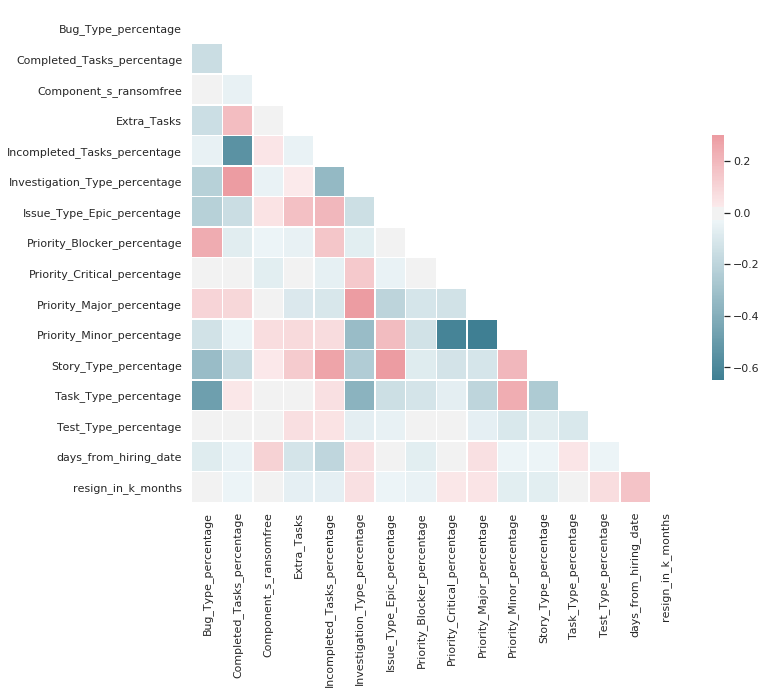

In [0]:
# Compute the correlation matrix for the numeric features
sns.set(style="white")

corr = dataset.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [0]:
co = corr.unstack()
sort_cor = co.sort_values(kind="quicksort")
pd.DataFrame(sort_cor[sort_cor > 0.8])

,,0
Bug_Type_percentage,Bug_Type_percentage,1.0
Test_Type_percentage,Test_Type_percentage,1.0
Task_Type_percentage,Task_Type_percentage,1.0
Story_Type_percentage,Story_Type_percentage,1.0
Priority_Minor_percentage,Priority_Minor_percentage,1.0
Priority_Major_percentage,Priority_Major_percentage,1.0
Priority_Critical_percentage,Priority_Critical_percentage,1.0
Priority_Blocker_percentage,Priority_Blocker_percentage,1.0
Issue_Type_Epic_percentage,Issue_Type_Epic_percentage,1.0
Investigation_Type_percentage,Investigation_Type_percentage,1.0


In [0]:
sort_cor = co.sort_values(kind="quicksort")
pd.DataFrame(sort_cor[sort_cor < -0.8])

,,0


### Dealing with Categorial features

In [0]:
if(not drop_categorical):
  categories = ['Seniority_level','Salary_Level','Department']
  # Change to categorial data type
  for col in categories:
      dataset[col] = dataset[col].astype('category')
  # Change to numeric data type
  for col in num_cols:
      dataset[col] = dataset[col].astype('float64')

In [0]:
print(dataset.Seniority_level.unique())
print(dataset.Salary_Level.unique())

[NaN, B, C, E, D]
Categories (4, object): [B, C, E, D]
[NaN, C, E, D, B]
Categories (4, object): [C, E, D, B]


In [0]:
#Install package
import sys
!{sys.executable} -m pip install category_encoders

In [0]:
# Dealing with categorial features
import category_encoders as ce

if(not drop_categorical):
  encoder = ce.BinaryEncoder(cols = ['Department'])
  dataset = encoder.fit_transform(dataset)
  
  dataset['Seniority_level'] = dataset['Seniority_level'].map({'B':'1','C':'2','D':'3', 'E':'4'})
  dataset['Salary_Level'] = dataset['Salary_Level'].map({'B':'1','C':'2','D':'3', 'E':'4'})
  
  dataset['Seniority_level'] = dataset['Seniority_level'].astype('float64')
  dataset['Salary_Level'] = dataset['Salary_Level'].astype('float64')

# Modeling

In [0]:
X = dataset.drop('resign_in_k_months', axis=1)
Y = dataset['resign_in_k_months']

## Classification Model

In [0]:
import random as rm

# Separate dataset to groups of the same employees
assignees = X.Assignee.unique()

# Shuffle method
rm.shuffle(assignees)

# Take 20% for test set
test_ind = range(0,round(len(assignees)*0.2))
train_ind = range(round(len(assignees)*0.2),len(assignees))

### LGBM

In [0]:
import lightgbm as lgb

# Split dataset with different employees in the training set and testing set
X_test, y_test = X[X['Assignee'].isin(assignees[test_ind])], Y[X[X['Assignee'].isin(assignees[test_ind])].index]
X_train, y_train = X[X['Assignee'].isin(assignees[train_ind])], Y[X[X['Assignee'].isin(assignees[train_ind])].index]

groups = X_train['Assignee']

X_test = X_test.drop(['Assignee'], axis = 1)
X_train = X_train.drop(['Assignee'], axis = 1)

generate_data = False

In [0]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 913 entries, 1 to 1155
Data columns (total 22 columns):
Bug_Type_percentage              913 non-null float64
Completed_Tasks_percentage       913 non-null float64
Component_s_ransomfree           913 non-null float64
Department_0                     913 non-null int64
Department_1                     913 non-null int64
Department_2                     913 non-null int64
Department_3                     913 non-null int64
Department_4                     913 non-null int64
Extra_Tasks                      913 non-null float64
Incompleted_Tasks_percentage     913 non-null float64
Investigation_Type_percentage    913 non-null float64
Issue_Type_Epic_percentage       913 non-null float64
Priority_Blocker_percentage      913 non-null float64
Priority_Critical_percentage     913 non-null float64
Priority_Major_percentage        913 non-null float64
Priority_Minor_percentage        913 non-null float64
Salary_Level                     649 non

#### Generate synthetic data

In [0]:
# Data generation and balancing
from imblearn.over_sampling import SMOTE

if(generate_data):
  sm = SMOTE(random_state=27, ratio=1.0)
  X_train, y_train = sm.fit_sample(X_train, y_train)

#### Normalization

In [0]:
# Normaliize data
from sklearn import preprocessing

# Get column names first
names = X.columns

# Create the Scaler object
scaler = preprocessing.StandardScaler()

# Fit your data on the scaler object
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.fit_transform(X_test[num_cols])

# Put in DataFrame
X_train = pd.DataFrame(X_train, columns=names)
X_test = pd.DataFrame(X_test, columns=names)

In [0]:
if(drop_categorical):
  lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
  lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train, free_raw_data=False)
else:
  lgb_train = lgb.Dataset(X_train, y_train, categorical_feature = ['Department_0', 'Department_1', 'Department_2', 'Department_3', 'Department_4', 'Salary_Level', 'Seniority_level'], free_raw_data=False)
  lgb_test = lgb.Dataset(X_test, y_test, categorical_feature = ['Department_0', 'Department_1', 'Department_2', 'Department_3', 'Department_4', 'Salary_Level', 'Seniority_level'], reference=lgb_train, free_raw_data=False)


In [0]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 913 entries, 1 to 1155
Data columns (total 22 columns):
Bug_Type_percentage              913 non-null float64
Completed_Tasks_percentage       913 non-null float64
Component_s_ransomfree           913 non-null float64
Department_0                     913 non-null int64
Department_1                     913 non-null int64
Department_2                     913 non-null int64
Department_3                     913 non-null int64
Department_4                     913 non-null int64
Extra_Tasks                      913 non-null float64
Incompleted_Tasks_percentage     913 non-null float64
Investigation_Type_percentage    913 non-null float64
Issue_Type_Epic_percentage       913 non-null float64
Priority_Blocker_percentage      913 non-null float64
Priority_Critical_percentage     913 non-null float64
Priority_Major_percentage        913 non-null float64
Priority_Minor_percentage        913 non-null float64
Salary_Level                     649 non

In [0]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(913, 22)
(913,)
(203, 22)
(203,)


In [0]:
x_set = pd.DataFrame(X_train, columns=names)

In [0]:
pd.Index(y_train).value_counts()

0    901
1     12
Name: resign_in_k_months, dtype: int64

In [0]:
pd.Index(y_test).value_counts()

0    194
1      9
Name: resign_in_k_months, dtype: int64

In [0]:
#Select Hyper-Parameters
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 64,
          'learning_rate': 0.07,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 1.2,
          'reg_lambda': 1.2,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          #'scale_pos_weight': 99.985,
          'is_unbalance': True,
          'num_class' : 1,
          'metric' : 'binary_error'
          }

# Create parameters to search
gridParams = {
    'learning_rate': [0.04, 0.07],
    'n_estimators': [50,60],
    'num_leaves': [20, 40, 60],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501], 
    'colsample_bytree' : [0.5, 0.8],
    'subsample' : [0.5,0.7],
    'reg_alpha' : [1, 1.2],
    'reg_lambda' : [1.2, 1.4],
    }

# Create classifier to use
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 5, 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          is_unbalance = params['is_unbalance'],
          #scale_pos_weight = params['scale_pos_weight']
                        )

In [0]:
mdl.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq', 'max_bin', 'is_unbalance'])

In [0]:
from sklearn.model_selection import GroupKFold

group_kfold = GroupKFold(n_splits=4)
group_kfold.get_n_splits(X_train, y_train, groups)

4

In [0]:
# Create the grid
from sklearn.model_selection import GridSearchCV

gkf = list(GroupKFold(n_splits=4).split(X_train,y_train,groups))

grid = GridSearchCV(mdl, gridParams, verbose=2, cv=gkf, n_jobs=-1)

In [0]:
# Run the grid
grid.fit(X_train, y_train,)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 4 folds for each of 192 candidates, totalling 768 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 718 tasks      | elapsed:  1.0min


{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.04, 'n_estimators': 50, 'num_leaves': 20, 'objective': 'binary', 'random_state': 501, 'reg_alpha': 1, 'reg_lambda': 1.2, 'subsample': 0.5}
0.968236582694414


[Parallel(n_jobs=-1)]: Done 768 out of 768 | elapsed:  1.1min finished


In [0]:
# Using parameters already set above, replace in the best from the grid search
params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate']
params['n_estimators'] = grid.best_params_['n_estimators']
params['objective'] = grid.best_params_['objective']
params['random_state'] = grid.best_params_['random_state']
params['subsample'] = grid.best_params_['subsample']

In [0]:
%%time
lgbm = lgb.train(params, lgb_train, num_boost_round=300)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


CPU times: user 145 ms, sys: 88.8 ms, total: 234 ms
Wall time: 216 ms


In [0]:
y_prob = lgbm.predict(X_test)
y_prob = pd.DataFrame(y_prob)

### Features Importance

In [0]:
feature_importances = pd.DataFrame(grid.feature_importances_, index = X.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances

In [0]:
fea_imp = pd.DataFrame({'imp': grid.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('LGBM - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

### Evaluation

In [0]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, roc_auc_score

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# calculate AUC
auc = roc_auc_score(y_test, y_prob)
print('AUC: %.3f' % auc)

# Find optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Turn probability to 0-1 (binary output) using the best threshold
y_pred = np.where(y_prob > optimal_threshold, 1, 0) 

AUC: 0.788


In [0]:
confusion_matrix(y_test, y_pred)

array([[113,  81],
       [  1,   8]])

<Figure size 432x288 with 0 Axes>

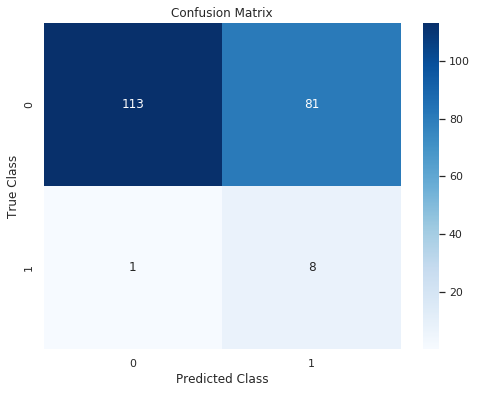

In [0]:
# Confusion Matrix
plt.figure()
cm = confusion_matrix(y_test, y_pred)
labels = ['0', '1']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [0]:
# Calculate scores
print("Recall: {0}".format(round(recall_score(y_test, y_pred),4)))
print("Precision: {0}".format(round(precision_score(y_test, y_pred),4)))
print("F1-score: {0}".format(f1_score(y_test, y_pred)))

Recall: 0.8889
Precision: 0.0899
F1-score: 0.16326530612244897
